## Polynomial Sequence to Sequence Encoder

In this notebook I am exploring building a sequence-to-sequence encoder that will accept as input a factored polynomial and predict the expanded version based on input characters (not a mathematical scheme).

My pre-processing steps include splitting sequences to individual characters, tokenization,  identifier vectorization and implementing padding to target sequences.

The model architecture used is an Encoder-Decoder network with three LSTM layers in the Encoder and 1 LSTM layer in the Decoder. I use a sparse catagorical cross-entropy loss function and Adam optimizer.

I am currently working on implementation of the inference model which successfully translates the decoder output to the expanded polynomial string, but have saved the trained model (model trained on data in file entitled "data.txt") as "seq2seq_2_trained.h5". This was the second model architecture explored, the first model architecture, trained on the same data, was saved as "seq2seq_trained.h5".

In [1]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, TimeDistributed
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences, to_categorical
import numpy as np
import pandas as pd
import collections
import re
from sklearn.model_selection import train_test_split

### Load in and prepare the data

We are going to be dealing with an input sequence of characters and an output sequence of characters (of different lengths). The input sequences will be factored formes of polynomials while the output (target) sequences will be the expanded forms.

In [6]:
data= pd.read_csv("data.txt", sep="=", header=None)
data.columns=["factored", "expanded"]
data.head()

,factored,expanded
0,(7-3*z)*(-5*z-9),15*z**2-8*z-63
1,-9*s**2,-9*s**2
2,(2-2*n)*(n-1),-2*n**2+4*n-2
3,x**2,x**2
4,(4-x)*(x-23),-x**2+27*x-92


In [7]:
#just to speed things along lets let the data set be just 2000 pairs long
print(data.shape)
data = data.iloc[:10000,:]
print(data.shape)

(1000000, 2)
(10000, 2)


In [8]:
#split the sequences into a list each of characters
def seq_splitter(seq):
    char_list = list(seq)
    return char_list

#apply it to the data frame
data.factored = data.factored.apply(lambda x: seq_splitter(x))

data.expanded = data.expanded.apply(lambda x: seq_splitter(x))

data.head()

,factored,expanded
0,"[(, 7, -, 3, *, z, ), *, (, -, 5, *, z, -, 9, )]","[1, 5, *, z, *, *, 2, -, 8, *, z, -, 6, 3]"
1,"[-, 9, *, s, *, *, 2]","[-, 9, *, s, *, *, 2]"
2,"[(, 2, -, 2, *, n, ), *, (, n, -, 1, )]","[-, 2, *, n, *, *, 2, +, 4, *, n, -, 2]"
3,"[x, *, *, 2]","[x, *, *, 2]"
4,"[(, 4, -, x, ), *, (, x, -, 2, 3, )]","[-, x, *, *, 2, +, 2, 7, *, x, -, 9, 2]"


In [9]:
#what is the maximum length of the input sentences
MAX_LEN= max(list(map(lambda x: len(x), data.factored)))
print(MAX_LEN)

29


In [10]:
#add a <BOS> (Beginning of Sequence) and <EOS> (End of Sequence) tag to the sequences for decoder input
def tagger(decoder_input_sequence):
    bos = "<BOS>"
    eos = "<EOS>"
    for seq in decoder_input_sequence:
        seq.insert(0,bos)
        seq.append(eos)
#     final_target = [seq.insert(0,bos) + seq + eos for seq in decoder_input_sequence]
    return decoder_input_sequence

In [11]:
#tag the beginning and end of the expansions sequences
expansions = tagger(data.expanded)

In [76]:
# #define the vocabulary, determine size of one-hot encoded sequence vector
# #the vocabulary will be a collection of characters in this context, not words

VOCAB_SIZE = 31 # adding 2+29 for <BOS> and <EOS> tags not sure if this is correct- Sofia come back to this...

def vocab_creator(seq_lists, VOCAB_SIZE):
    
    tokenizer = Tokenizer(num_words = VOCAB_SIZE)
    tokenizer.fit_on_texts(seq_lists)
    dictionary = tokenizer.word_index
    
    word2idx = {}
    idx2word = {}
    
    for i, j in dictionary.items():
        
        if j < VOCAB_SIZE:
            word2idx[i] = j
            idx2word[j] = i
            
        if j >= VOCAB_SIZE-1:
            continue
    
    return word2idx, idx2word



In [77]:
# encoder_input_text = data.factored
word2idx, idx2word = vocab_creator(seq_lists = factors + expansions, VOCAB_SIZE=VOCAB_SIZE)


In [78]:
print(word2idx)
print(idx2word)

{'*': 1, '-': 2, '2': 3, '(': 4, ')': 5, '1': 6, '+': 7, '<bos>': 8, '<eos>': 9, '4': 10, '3': 11, '6': 12, '8': 13, '5': 14, '7': 15, '0': 16, 'n': 17, 's': 18, 'i': 19, '9': 20, 'o': 21, 'a': 22, 't': 23, 'c': 24, 'k': 25, 'x': 26, 'z': 27, 'y': 28, 'h': 29, 'j': 30}
{1: '*', 2: '-', 3: '2', 4: '(', 5: ')', 6: '1', 7: '+', 8: '<bos>', 9: '<eos>', 10: '4', 11: '3', 12: '6', 13: '8', 14: '5', 15: '7', 16: '0', 17: 'n', 18: 's', 19: 'i', 20: '9', 21: 'o', 22: 'a', 23: 't', 24: 'c', 25: 'k', 26: 'x', 27: 'z', 28: 'y', 29: 'h', 30: 'j'}


In [17]:
#define the factored sequences
factors = data.factored

In [21]:
#now tokenize the bag of words to a bag of IDs- transform each sequence of characters into sequences of ids
def text2seq(factors, expansions, VOCAB_SIZE):
    
    tokenizer = Tokenizer(num_words = VOCAB_SIZE)
    tokenizer.fit_on_texts(factors + expansions)
    factor_sequences = tokenizer.texts_to_sequences(factors)
    expansion_sequences = tokenizer.texts_to_sequences(expansions)
    
    return factor_sequences, expansion_sequences

In [22]:
factor_sequences, expansion_sequences = text2seq(factors, expansions, VOCAB_SIZE=VOCAB_SIZE)

In [25]:
#now implement padding to the sequences- use the max sequence length we found earlier
#(we expect the max encoder input length to be < the max decoder input length)

def padding(factor_sequences, expansion_sequences, MAX_LEN):
    
    factors_padded = pad_sequences(factor_sequences, maxlen = MAX_LEN, padding = 'post', truncating = 'post')
    expansions_padded = pad_sequences(expansion_sequences, maxlen = MAX_LEN, padding = 'post', truncating = 'post')
    
    return factors_padded, expansions_padded


In [26]:
factors_padded, expansions_padded = padding(factor_sequences, expansion_sequences, MAX_LEN=MAX_LEN)

### Now define the model architecture and train!?

In [36]:
# def seq2seq_model(HIDDEN_DIM=300, EMBEDDING_DIM=10):
    
#     #first the encoder layers
#     encoder_inputs = Input(shape = (MAX_LEN, ), 
#                            dtype = 'int32')
#     embed_layer = Embedding(input_dim = VOCAB_SIZE,
#                            output_dim = EMBEDDING_DIM,
#                            input_length = MAX_LEN)
#     encoder_embedding = embed_layer(encoder_inputs) #sofia what is embed_layer() doing?
#     encoder_LSTM = LSTM(HIDDEN_DIM,
#                        return_state = True)
#     encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)
    
#     #now the decoder layers
#     decoder_inputs = Input(shape = (MAX_LEN, ), 
#                           dtype = 'int32')
#     decoder_embedding = embed_layer(decoder_inputs)
#     decoder_LSTM = LSTM(HIDDEN_DIM, 
#                        return_state = True, 
#                        return_sequences = True)
#     #setting the initial state of the LSTM layer as the final state of the encoder LSTM layer
#     decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=[state_h, state_c])
    
#     #the final Dense layer ( applying a layer to every temporal input slice )
#     outputs = TimeDistributed(Dense(VOCAB_SIZE, activation = 'softmax'))(decoder_outputs)
#     model = Model([encoder_inputs, decoder_inputs], outputs)
    
#     return model

In [37]:
# model = seq2seq_model(HIDDEN_DIM=20)
# model.summary()

In [38]:
# #now let's train the model!!

# model.compile(optimizer = 'adam',
#              loss = 'categorical_crossentropy',
#              metrics = ['accuracy'])

In [39]:
# en_in_train, en_in_test, de_in_train, de_in_test, de_out_train, de_out_test = train_test_split(encoder_input_data, decoder_input_data, decoder_output_data, test_size=0.3)
# print(en_in_train.shape, de_in_train.shape, de_out_train.shape)


In [40]:
# BATCH_SIZE = 700
# EPOCHS = 5 #lets start here

In [41]:
# #make sure to save the training progress
# history = model.fit([en_in_train, de_in_train], de_out_train,
#                    epochs = EPOCHS, 
#                    batch_size = BATCH_SIZE)

### Let's save the model and visualize the learning history!


In [59]:
HIDDEN_DIM = 300
EMBEDDING_DIM = 10

#Encoder
encoder_inputs = Input(shape = (MAX_LEN,))

#Embedding layer
enc_emb = Embedding(input_dim = VOCAB_SIZE,
                    output_dim = EMBEDDING_DIM,
                    input_length = MAX_LEN,
                   trainable = True)(encoder_inputs)

#Encoder LSTM 1
encoder_lstm1 = LSTM(HIDDEN_DIM, 
                    return_sequences = True,
                    return_state = True, 
                    dropout = 0.4, 
                    recurrent_dropout = 0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

#ENcoder LSTM 2
encoder_lstm2 = LSTM(HIDDEN_DIM, 
                    return_sequences = True,
                    return_state = True, 
                    dropout = 0.4, 
                    recurrent_dropout = 0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

#Encoder LSTM 3
encoder_lstm3 = LSTM(HIDDEN_DIM, 
                    return_sequences = True,
                    return_state = True, 
                    dropout = 0.4, 
                    recurrent_dropout = 0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output1)

#now set up the decoder using the encoder_states as the initial decoder state
decoder_inputs = Input(shape=(None, ))

#Embedding layer
dec_emb_layer = Embedding(input_dim = VOCAB_SIZE,
                    output_dim = EMBEDDING_DIM,
                    trainable = True)
dec_emb = dec_emb_layer(decoder_inputs)

#Decoder LSTM
decoder_lstm = LSTM(HIDDEN_DIM, 
                   return_sequences = True, 
                   return_state = True, 
                   dropout = 0.4, 
                   recurrent_dropout = 0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

#Dense layer
decoder_dense = TimeDistributed(Dense(VOCAB_SIZE, activation = 'softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 29)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 29, 10)       310         ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 lstm_4 (LSTM)                  [(None, 29, 300),    373200      ['embedding_2[0][0]']            
                                 (None, 300),                                               

In [60]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor = 'loss', mode = 'min', verbose =1, patience =2)


In [61]:
#now split up the data for training and testing
factors_train, factors_test, expansions_train, expansions_test = train_test_split(factors_padded, expansions_padded, test_size =0.3)


In [62]:
BATCH_SIZE = 1000
EPOCHS = 5

In [63]:
#now let's train the model- pass the factors and expanded sequences, excluding the last character in the expanded sequences as input
#as output pass a re-shaped expansions tensor composed of every character in the expansions from the 2nd index onwards
history = model.fit([factors_train, expansions_train[:,:-1]],
                   expansions_train.reshape(expansions_train.shape[0], expansions_train.shape[1],1)[:,1:],
                   epochs = EPOCHS, 
                   batch_size = BATCH_SIZE, 
                   callbacks = [es], 
                   )

Epoch 1/5
7/7 [==============================] - 29s 3s/step - loss: 3.1264
Epoch 2/5
7/7 [==============================] - 23s 3s/step - loss: 1.9427
Epoch 3/5
7/7 [==============================] - 24s 3s/step - loss: 1.7236
Epoch 4/5
7/7 [==============================] - 24s 3s/step - loss: 1.6475
Epoch 5/5
7/7 [==============================] - 25s 4s/step - loss: 1.6202


In [64]:
print(history.history.keys())

dict_keys(['loss'])


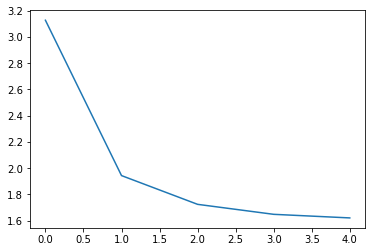

In [65]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title("Training Loss Over Epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")
plt.show()

In [66]:
#save the model for good measure
model.save('seq2seq_2_trained.h5')

### Now define the encoder/decoder inference model

To accept an input factored sequence and return a predicted expansion.

In [93]:
#encode the input sequence to get the feature vector
encoder_model = Model(inputs = encoder_inputs, outputs = [encoder_outputs, state_h, state_c])

#decoder setup
#below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(HIDDEN_DIM, ))
decoder_state_input_c = Input(shape=(HIDDEN_DIM, ))
decoder_hidden_state_input = Input(shape=(MAX_LEN, HIDDEN_DIM))

#get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# to predict the next character in the sequence, set the initial states
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

#a dense softmax layer to generate the probability distribution over the target vocab
decoder_outputs2 = decoder_dense(decoder_outputs2)

#the final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])



In [94]:
#now define a function which accepts the input text and outputs the predicted expansion

def decode_sequence(input_seq):
    
    #encode the input as state vectors
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)
    
    #generate empty target sequence of length 1
    target_seq = np.zeros((1,1))
    
    #populate the first character of the target sequence with the beginning of sequence tag
    target_seq[0,0] = word2idx['<bos>']
    
    stop_condition = False
    decoded_sequence = ''
    
    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]+[e_out, e_h, e_c])
        
        #sample a token
        sampled_token_index = np.argmax(output_tokens[0,-1,:])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if sampled_token_index!= '<eos>':
            decoded_sequence +=',' + sampled_token
            
        #the exit condition is either hitting the max length or finding a stop word
        if sampled_token == '<eos>' or len(decoded_sequence.split(","))>=MAX_LEN-1:
            stop_condition = True
            
        #update the target sequence (of length 1)
        target_seq = np.zeros((1,1))
        target_seq[0,0] = sampled_token_index
        
        #update the internal states
        (e_h, e_c) = (h,c)
        
    return decoded_sequence

In [96]:
#now define the functions that will convert between numeric and string representations
#make sure to define the target character index

#recal that we already have dictionaries holding the word2idx and idx2word values

#from sequence to expansion
def seq2exp(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != word2idx['<eos>'] and i != word2idx['<bos>']:
            newString = newString + idx2word[i] + ','
            
    return newString

#from expansion to sequence

def exp2seq(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + word2idx[i] + ','
            
    return newString

In [97]:
#now lets generate some predictions

for i in range(0, 19):
    print ('Factor:', seq2exp(factors_train[i]))
    print ('Original expansion:', seq2exp(expansions_train[i]))
    print ('Predicted expansion:', decode_sequence(factors_train[i].reshape(1,
           MAX_LEN)))
    print('\n')

Factor: (,-,5,*,c,-,1,1,),*,(,c,+,1,2,),
Original expansion: -,5,*,c,*,*,2,-,7,1,*,c,-,1,3,2,
1/1 [==============================] - 0s 377ms/step


ValueError: in user code:

    File "/usr/local/lib/python3.9/site-packages/keras/engine/training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.9/site-packages/keras/engine/training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.9/site-packages/keras/engine/training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.9/site-packages/keras/engine/training.py", line 1791, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.9/site-packages/keras/engine/input_spec.py", line 200, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Exception encountered when calling layer "model_7" (type Functional).
    
    Layer "lstm_7" expects 5 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'model_7/embedding_3/embedding_lookup/Identity_1:0' shape=(None, 1, 10) dtype=float32>]
    
    Call arguments received by layer "model_7" (type Functional):
      • inputs=('tf.Tensor(shape=(None, 1), dtype=float32)', 'tf.Tensor(shape=(None, 29, 300), dtype=float32)', 'tf.Tensor(shape=(None, 300), dtype=float32)', 'tf.Tensor(shape=(None, 300), dtype=float32)')
      • training=False
      • mask=None
